<a id='contents'><h1>Quantifying Centeredness of flower petal spots</h1></a>

Mimulus flowers often develop central spots on their petals, in addition to many other types of spot patterning. Let's develop a method for identifying and comparing spot centeredness in our images of spots. 

There are still a lot of issues with the process of digitizing polygons, many are not creating correctly. But here we'll forge a ahead and draw up a pipeline for analyzing the polygons that are digitizing without problems. 

<h3>Contents</h3>

[Working through one flower](#P416F1)
- [recenter and scale petals and spots](#reSc)

<h2><a id='P416F1'>Working through one flower</a></h2>

Let's look at this process using one flower that digitized without problems, P416F1:

In [25]:
%% in matlab, setup work environment
imatlab_export_fig('print-png') %% sets inline plotting for jupyter instead of matlab's plotter
%% flower
fname = "P416F1";
%% working directory
wd="/Users/danthomas/Documents/speckling/center";
%% our petal structures with polygons are here, right now:
objDir="/Users/danthomas/Documents/speckling/make_polygons/matObjW_pol/";
%% they'll migrate to dougdir eventually...
%% jpegs are here
dougDir = "/Users/danthomas/Documents/speckling/dougRaster/Rotated_and_Cropped/";

In [26]:
cd(wd);
load(objDir + fname + ".mat") %% get the matlab struct for this flower
[a,b,c] = fileparts(Petals.fullName);
jpegName = char(dougDir + b + c); 

The flower looks like:

> In images.internal.initSize (line 71)
  In imshow (line 336)


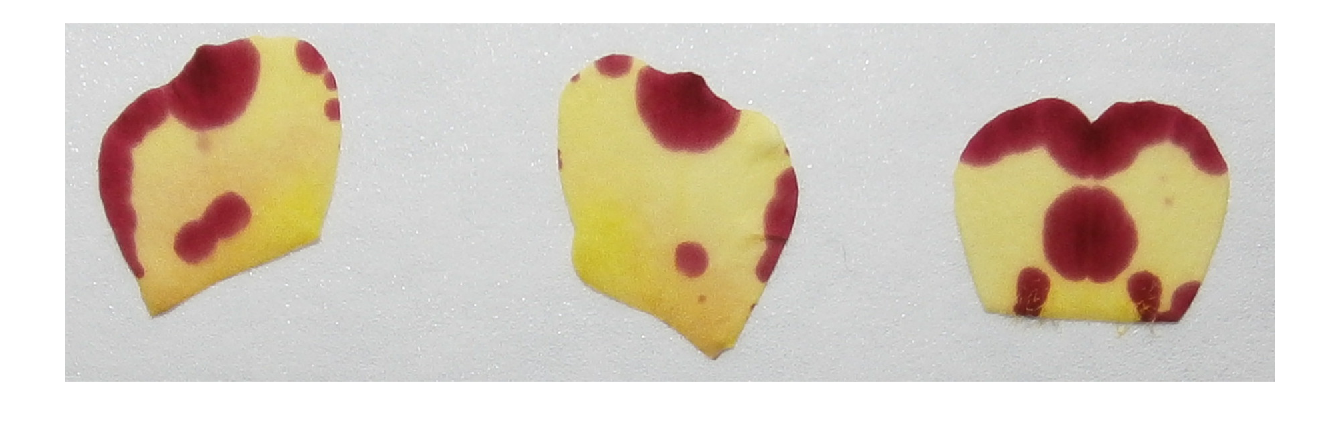

In [27]:
imshow(jpegName);

<a id='reSC'><h3> 1 - Recenter and scale petals and spots</h3></a>


ans =

    1.0000



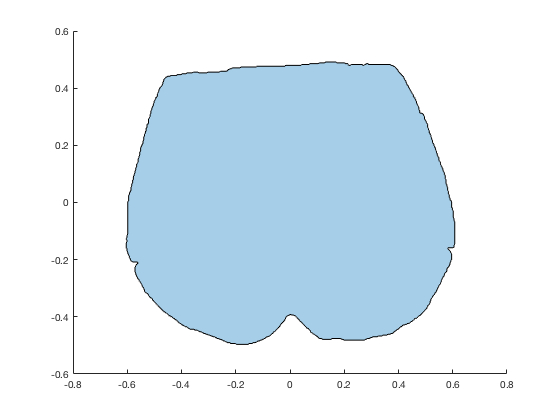

In [31]:
aa = Petals.Polys.right.petal(1);
bb = area(aa);
sc = 1/sqrt(bb);
cc = scale(aa, sc);
[cenX,cenY] = centroid(cc);
tPetal = translate(cc, -cenX, -cenY);
plot(tPetal)
area(tPetal)

We can use this info to scale and translate the spots, too:

In [32]:
counter = 1;
for i =  Petals.Polys.right.spots;
    cc = scale(i, sc);
    tSpot(counter) = translate(cc, -cenX, -cenY);
    counter = counter + 1;
end;

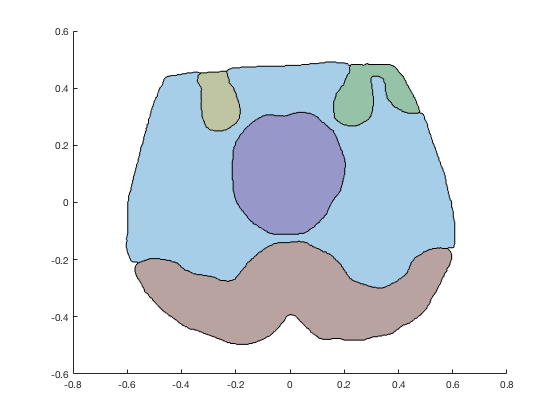

In [33]:
plot(tPetal);
hold on;
plot(tSpot)
hold off;

Kind of looks like a clown face.

<h3><a id='selPol'>2 - Select polygons for scoring</a></h3>

We'll try a very simple statistic for quantifying centeredness - average distance of polygon centroids from the center of the petal. However, centroids are misleading for some polygons, such as polygons that follow the exteriour line of the petal. Often, with these the centroid is outside of the polygon itself and not really representative the bulk of the area within that polygon, in terms of centeredness:

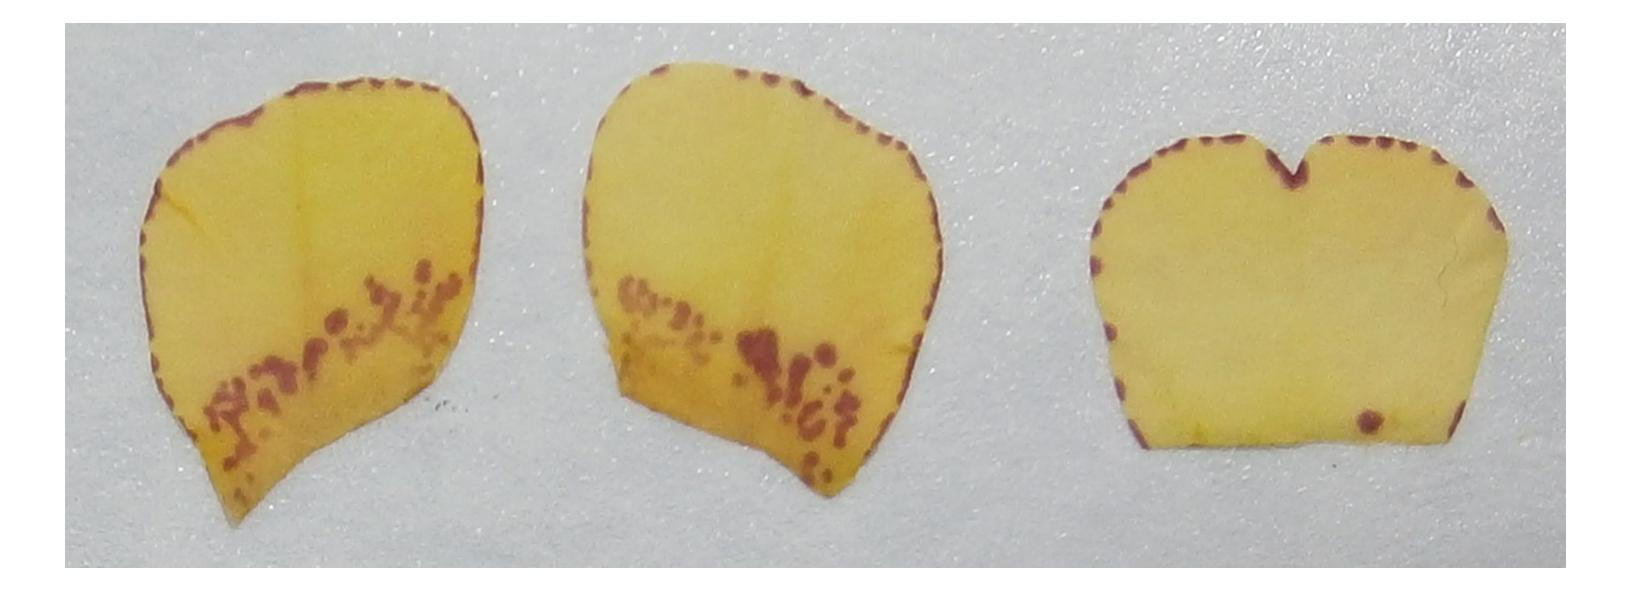

In [36]:
P371F2 = (objDir + "P371F2" + ".mat");
P371F2 = load(P371F2);
[a,b,c] = fileparts(P371F2.Petals.fullName);
jpegName = char(dougDir + b + c);
imshow(jpegName);

In [39]:
petal = P371F2.Petals.Polys.right.petal;
spot = P371F2.Petals.Polys.right.spots(1);
[cX, cY] = centroid(spot);
[CX, CY] = centroid(petal);

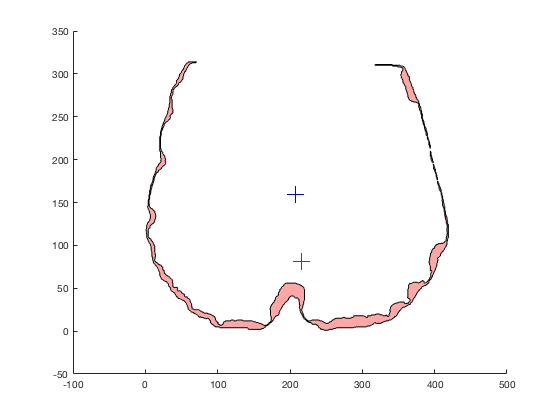

In [40]:
plot(spot, 'FaceColor','red');
hold on
plot(cX, cY, '+', 'MarkerSize', 15, 'Color', 'red');
plot(CX, CY, '+', 'MarkerSize', 15, 'Color', 'blue');
hold off

The blue cross represents the petal centroid, the red is the centroid of this ring-like polygon. This flower scores relatively high on our centeredness metric, because this major spot is concave, causing its center of gravity to be outside its polgyon borders, and because it is ~radially symmetric around the center. So its centroid falls close to the center of the petal. But this polygon is the exact opposite of centered - its spots exist as far from the center as they can!

Granted, this polygon happened because of errors in our digitization algorithms, and is actually many small spots on the real flower. But actual examples of continuous red pigmentation around the rim of petals may exist. And perhaps we can account partially for the errors of digitization here, in our algorithm. 

So, how can we detect polygons such as these? and what do we do with them when we find them?